# Basic CAM ad Grad-CAM Implementation on MNIST
Made to go along with the [Grad-CAM and Basic CNN Interpretability](https://berkan.xyz/posts/2021/12/gradCAM/) blog post.

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose

import matplotlib.pyplot as plt
import cv2
import numpy as np
import time

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [3]:
batch_size = 32

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([32, 1, 28, 28])
Shape of y: torch.Size([32]) torch.int64


## CAM
Note how the model has a very specific architecture, namely img → conv → max pooling → conv → max pooling → global average pooling → fully connected

[Official CAM Implementation](https://github.com/zhoubolei/CAM)

In [64]:
device = "cpu"

class CAM_CNN(nn.Module):
  def __init__(self):
    super(CAM_CNN, self).__init__()

    self.conv1 = nn.Sequential(         
      nn.Conv2d(
        in_channels=1,              
        out_channels=16,            
        kernel_size=5,              
        stride=1,                   
        padding=2,                  
      ),                              
      nn.ReLU(),                      
      nn.MaxPool2d(kernel_size=2),    
    )

    self.conv2 = nn.Sequential(         
      nn.Conv2d(16, 32, 5, 1, 2),
      nn.ReLU(),
      nn.MaxPool2d(2),
    )

    self.gap = nn.AvgPool2d(7) # GAP here!

    self.out = nn.Linear(32, 10)


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    y = self.gap(x)

    y = y.view(y.size(0), -1)

    y = self.out(y)
    return y, x


cam_model = CAM_CNN().to(device)
print(cam_model)

CAM_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (gap): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (out): Linear(in_features=32, out_features=10, bias=True)
)


In [65]:
cam_loss_fn = nn.CrossEntropyLoss() # Combines LogSoftmax and NLLLoss into one!

cam_optimizer = torch.optim.Adam(cam_model.parameters(), lr=0.005)

In [24]:
def cam_train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred, _ = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [25]:
def cam_test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred, _ = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    cam_train(train_dataloader, cam_model, cam_loss_fn, cam_optimizer)
    cam_test(test_dataloader, cam_model, cam_loss_fn)

print("Done!")

Epoch 1
-------------------------------
loss: 2.312581  [    0/60000]
loss: 1.576634  [ 6400/60000]
loss: 0.891458  [12800/60000]
loss: 0.561650  [19200/60000]
loss: 0.503685  [25600/60000]
loss: 0.424033  [32000/60000]
loss: 0.437022  [38400/60000]
loss: 0.352224  [44800/60000]
loss: 0.528976  [51200/60000]
loss: 0.259461  [57600/60000]
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.255100 

Epoch 2
-------------------------------
loss: 0.204092  [    0/60000]
loss: 0.193301  [ 6400/60000]
loss: 0.162606  [12800/60000]
loss: 0.245484  [19200/60000]
loss: 0.181319  [25600/60000]
loss: 0.177745  [32000/60000]
loss: 0.200338  [38400/60000]
loss: 0.173789  [44800/60000]
loss: 0.435940  [51200/60000]
loss: 0.198901  [57600/60000]
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.153676 

Epoch 3
-------------------------------
loss: 0.139533  [    0/60000]
loss: 0.164639  [ 6400/60000]
loss: 0.090518  [12800/60000]
loss: 0.201446  [19200/60000]
loss: 0.101285  [25600/60000]
loss: 0.107751  [32000/600

In [30]:
torch.save(cam_model.state_dict(), f"camModel{time.time()}.pth")

In [66]:
cam_model = CAM_CNN()
cam_model.load_state_dict(torch.load("camModel.pth"))

<All keys matched successfully>

===Example 0/1===
Truth: 7, Pred: 7


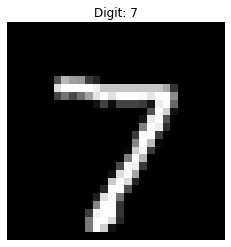

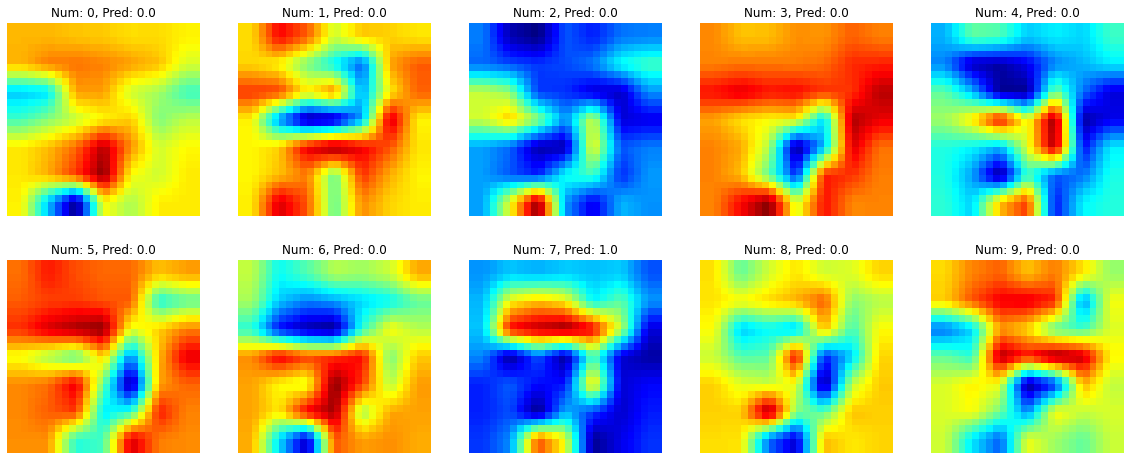

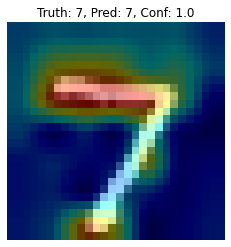

===Example 1/1===
Truth: 2, Pred: 2


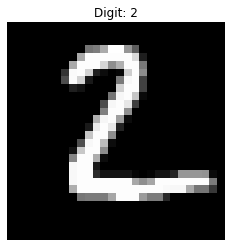

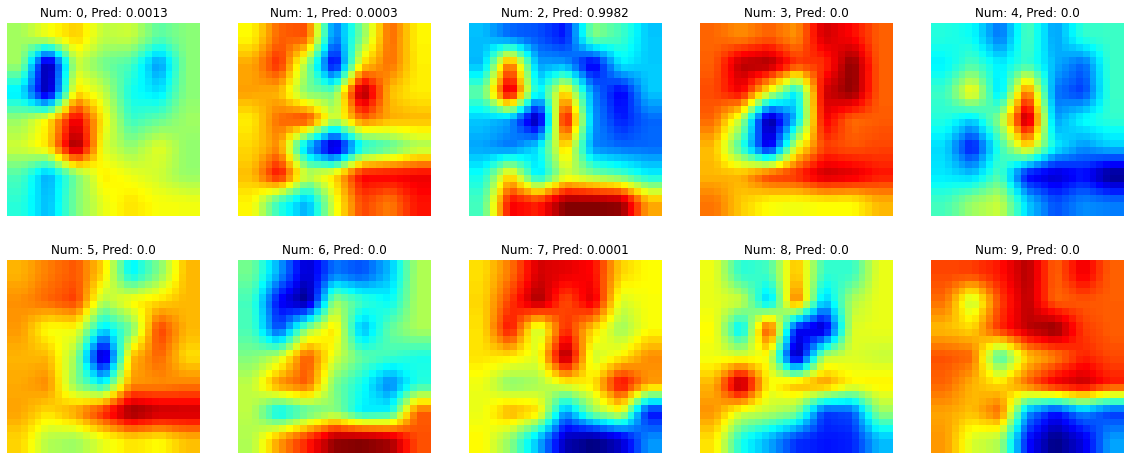

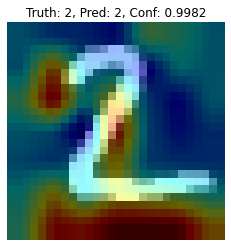

In [72]:
def cam_visualization(model, data, data_index=0, save=False):
  model.eval()

  with torch.no_grad():
    x, y = data[data_index][0], data[data_index][1]
    
    final_conv_output = 0
    cam_weights = 0

    pred, final_conv_output = model(x[None, :])

    for param in model.parameters():
      if param.size() == torch.Size([10, 32]):
        cam_weights = param
        break

    mult_res = torch.mul(cam_weights[:, :, None, None], final_conv_output)

    sum_res = torch.sum(mult_res, 1)

    pred = nn.functional.softmax(pred[0], dim=-1)

    # === Visualizations ===
    print(f"Truth: {y}, Pred: {pred.argmax(0)}")

    plt.axis("off")
    plt.title(f"Digit: {y}")
    plt.imshow(x.squeeze(), cmap="gray")
    if save:
      plt.savefig(f"../images/gradCAM/implemenPics/camDigit{data_index}")
      plt.close()
    else:
      plt.show()

    figure = plt.figure(figsize=(20, 8))
    cols, rows = 5, 2

    cam_heatmaps = []

    for i in range(0, cols * rows):
      heatmap = sum_res[i]
      heatmap = torch.sub(heatmap, torch.min(heatmap))
      heatmap = torch.div(heatmap, torch.max(heatmap))

      heatmap = cv2.resize(heatmap.numpy(), (28, 28))

      heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
      heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

      cam_heatmaps.append(heatmap)

      figure.add_subplot(rows, cols, i + 1)
      plt.title(f"Num: {i}, Pred: {round(pred[i].item(), 4)}")
      plt.axis("off")
      plt.imshow(heatmap)
    if save:
      plt.savefig(f"../images/gradCAM/implemenPics/camHeatmaps{data_index}")
      plt.close()
    else:
      plt.show()

    plt.figure()
    plt.title(f"Truth: {y}, Pred: {pred.argmax(0)}, Conf: {round(pred.amax(0).item(), 4)}")
    plt.axis("off")
    plt.imshow(x.squeeze(), cmap="gray")
    plt.imshow(cam_heatmaps[pred.argmax(0)], alpha=0.4)
    if save:
      plt.savefig(f"../images/gradCAM/implemenPics/camOverlay{data_index}")
      plt.close()
    else:
      plt.show()

num_graphs = 2
for i in range(num_graphs):
  print(f"===Example {i}/{num_graphs - 1}===")
  cam_visualization(cam_model, test_data, i, False)

## Grad-CAM and "Guided" Grad-CAM
Note how now the model doesn't need that global average pooling layer.

*Warning 1:* This is not the same implementation as found in the paper. In the paper they said that the $\alpha$ term is calculated with taking the graident of $y^c$ __before the softmax__ w.r.t each value in the output of the final conv layer. I found that using $y^c$ __after the softmax__ worked better. I believe this is because when calculating the gradient backwards I am setting the output to 0 for all classes and 1 for the target class. However, without the softmax, the outputs of the model are very far away from 0 and 1 for the other and target classes. I think (I am not sure) that this results in the final Grad-CAM output having most values that are 0 or less as the typical output for the target class is much higher than 1 and for the other classes is much less than 0 so the gradients are negative. Then when applying the ReLU to the Grad-CAM some images were just totally 0. But with the softmax applied the final outputs look much better. Perhaps some sort of normalization within the network could help.

*Warning 2*: I'm not actually implementing guided backprop/guided Grad-CAM here. I am just computing the gradients of the inputs w.r.t. the output predictions, I am not applying a ReLU to the gradients as they are propagating backwards which is what guided backprop does. I found that for this simple MNIST example it is sufficient not to use strict guided backprop.

If you want to see other implementations that helped me look here: 
- [Official Grad-CAM Implementation](https://github.com/ramprs/grad-cam)
- [Good implementation of various CNN visualization techniques in PyTorch](https://github.com/utkuozbulak/pytorch-cnn-visualizations)
- [Grad-CAM MNIST Keras](https://github.com/gorogoroyasu/mnist-Grad-CAM)

In [4]:
device = "cpu"

class Grad_CAM_CNN(nn.Module):
  def __init__(self):
    super(Grad_CAM_CNN, self).__init__()

    self.conv1 = nn.Sequential(         
      nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
      ),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
    )

    self.conv2 = nn.Sequential(
      nn.Conv2d(16, 32, 5, 1, 2),
      nn.ReLU(),
      nn.MaxPool2d(2),
    )

    # fully connected layer, output 10 classes
    self.out = nn.Linear(32 * 7 * 7, 10)

    self.input_gradients = None
  #   self.conv_gradients = None
  
  # def conv_gradients_hook(self, grad):
  #   self.conv_gradients = grad
  
  # def get_conv_gradients(self):
  #   return self.conv_gradients

  # def get_conv_activations(self, x):
  #   return self.conv2(self.conv1(x))

  def input_gradients_hook(self, grad):
    self.input_gradients = grad
  
  def get_input_gradients(self):
    return self.input_gradients

  def forward(self, x):
    x.requires_grad_()
    x.retain_grad()

    x.register_hook(self.input_gradients_hook)

    x = self.conv1(x)
    x = self.conv2(x)
    
    # x.requires_grad = True

    # h = x.register_hook(self.conv_gradients_hook)
    
    # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
    y = x.view(x.size(0), -1)
    y = self.out(y)
    
    return nn.functional.log_softmax(y, dim=1), x

grad_cam_model = Grad_CAM_CNN().to(device)

print(grad_cam_model)

Grad_CAM_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [5]:
grad_cam_loss_fn = nn.NLLLoss()

grad_cam_optimizer = torch.optim.Adam(grad_cam_model.parameters(), lr=0.004)

In [6]:
def grad_cam_train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred, _ = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def grad_cam_test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred, _ = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    grad_cam_train(train_dataloader, grad_cam_model, grad_cam_loss_fn, grad_cam_optimizer)
    grad_cam_test(test_dataloader, grad_cam_model, grad_cam_loss_fn)

    torch.save(grad_cam_model.state_dict(), f"gradCAMModel{time.time()}.pth")
    print("Saved")

print("Done!")

Epoch 1
-------------------------------
loss: 2.308207  [    0/60000]
loss: 0.246816  [ 3200/60000]
loss: 0.038624  [ 6400/60000]
loss: 0.081101  [ 9600/60000]
loss: 0.034567  [12800/60000]
loss: 0.019158  [16000/60000]
loss: 0.010167  [19200/60000]
loss: 0.046144  [22400/60000]
loss: 0.158586  [25600/60000]
loss: 0.056879  [28800/60000]
loss: 0.107215  [32000/60000]
loss: 0.077080  [35200/60000]
loss: 0.133431  [38400/60000]
loss: 0.113873  [41600/60000]
loss: 0.085254  [44800/60000]
loss: 0.220727  [48000/60000]
loss: 0.104255  [51200/60000]
loss: 0.003356  [54400/60000]
loss: 0.033181  [57600/60000]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.072576 

Saved
Epoch 2
-------------------------------
loss: 0.022509  [    0/60000]
loss: 0.038559  [ 3200/60000]
loss: 0.059955  [ 6400/60000]
loss: 0.003402  [ 9600/60000]
loss: 0.046242  [12800/60000]
loss: 0.009224  [16000/60000]
loss: 0.019277  [19200/60000]
loss: 0.002573  [22400/60000]
loss: 0.029018  [25600/60000]
loss: 0.011813  [28800

In [ ]:
torch.save(grad_cam_model.state_dict(), f"gradCAMModel{time.time()}.pth")

In [8]:
grad_cam_model = Grad_CAM_CNN()
grad_cam_model.load_state_dict(torch.load("gradCAMModel.pth"))

<All keys matched successfully>

===Example 0/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 7, Pred: 7


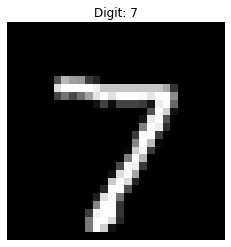

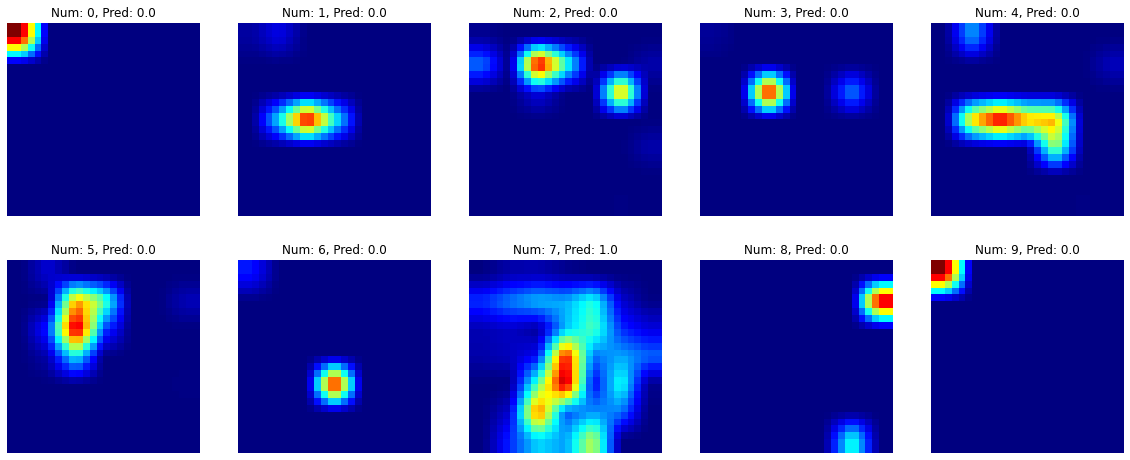

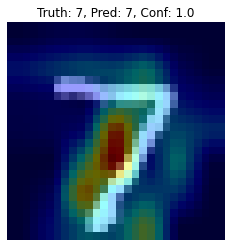

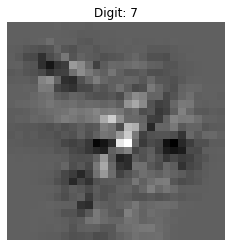

===Example 1/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 2, Pred: 2


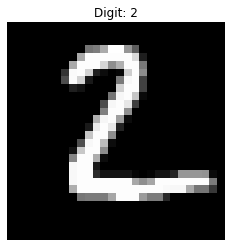

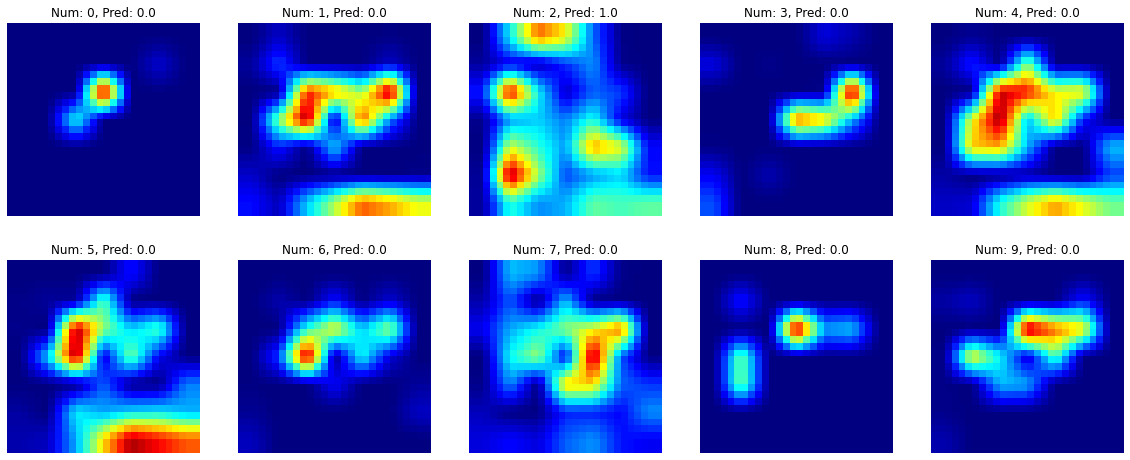

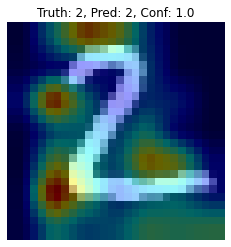

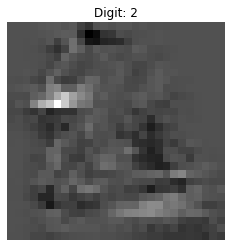

===Example 2/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 1, Pred: 1


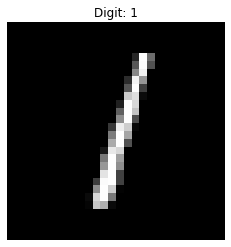

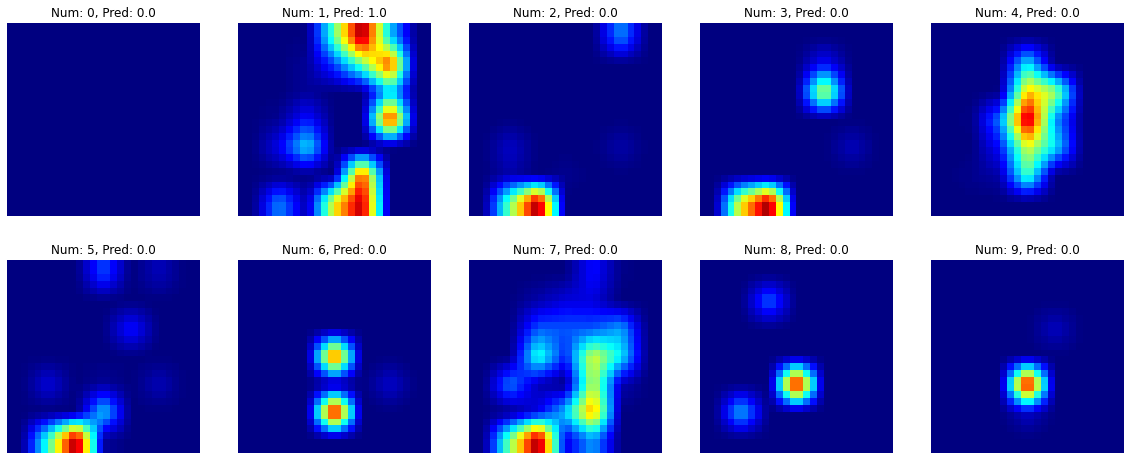

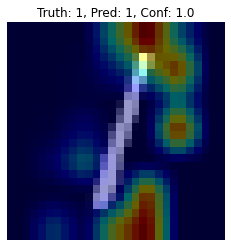

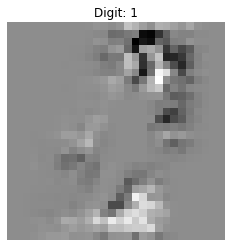

===Example 3/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 0, Pred: 0


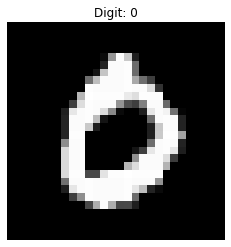

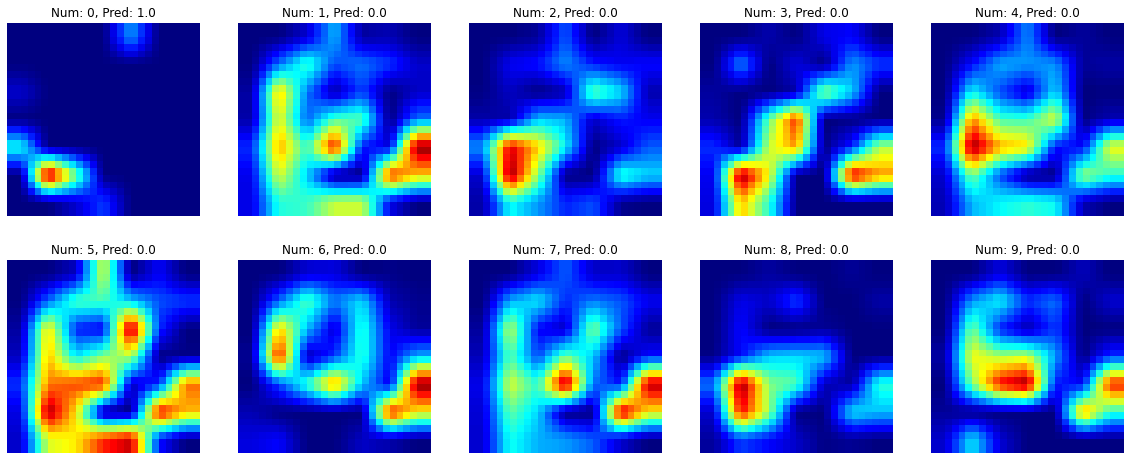

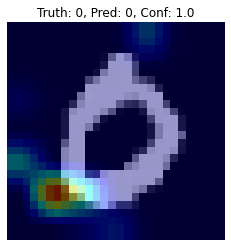

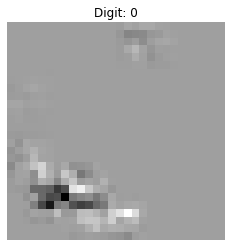

===Example 4/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 4, Pred: 4


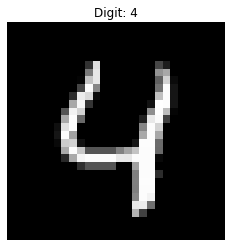

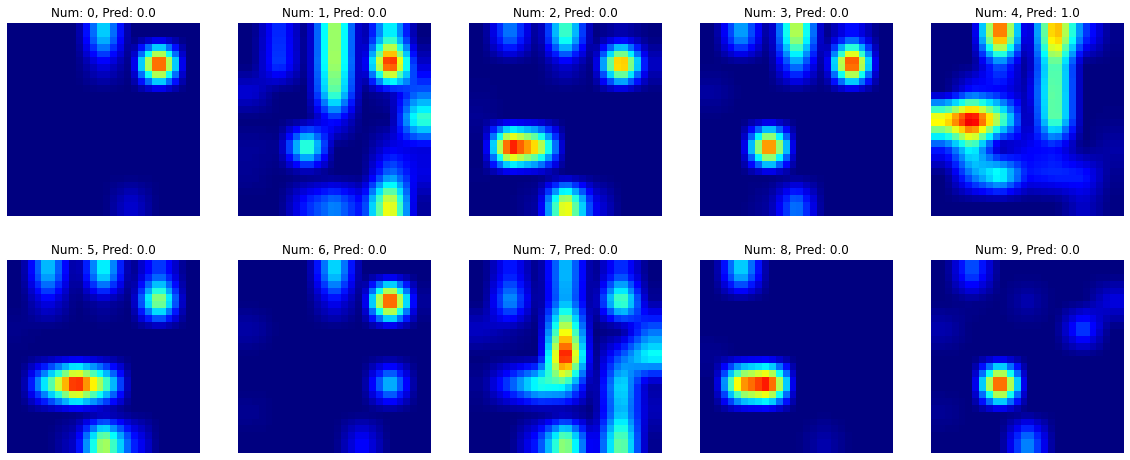

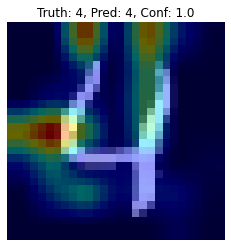

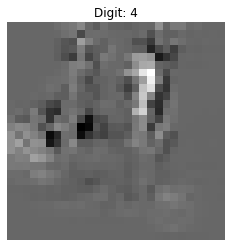

===Example 5/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 1, Pred: 1


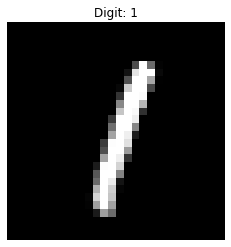

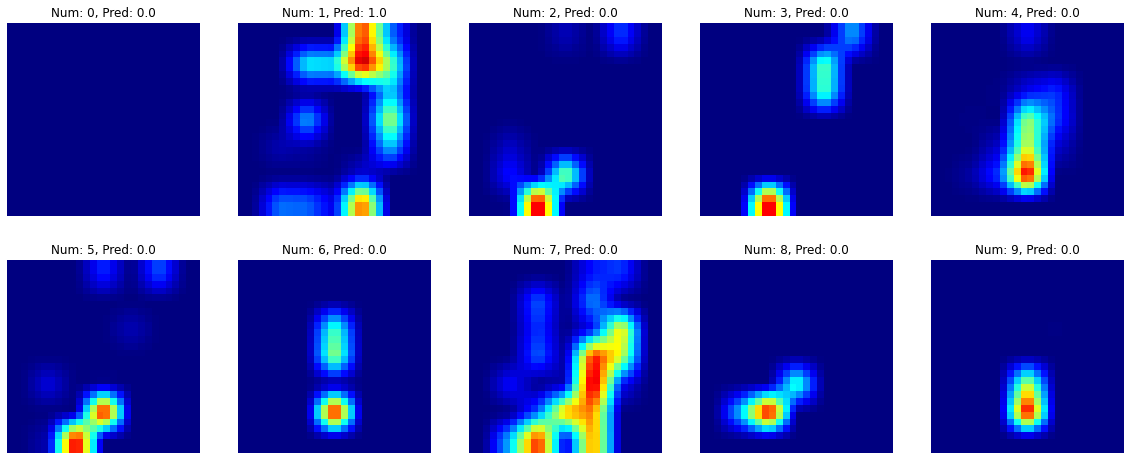

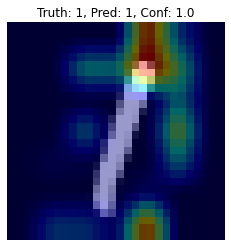

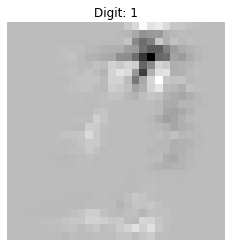

===Example 6/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 4, Pred: 4


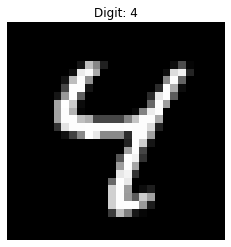

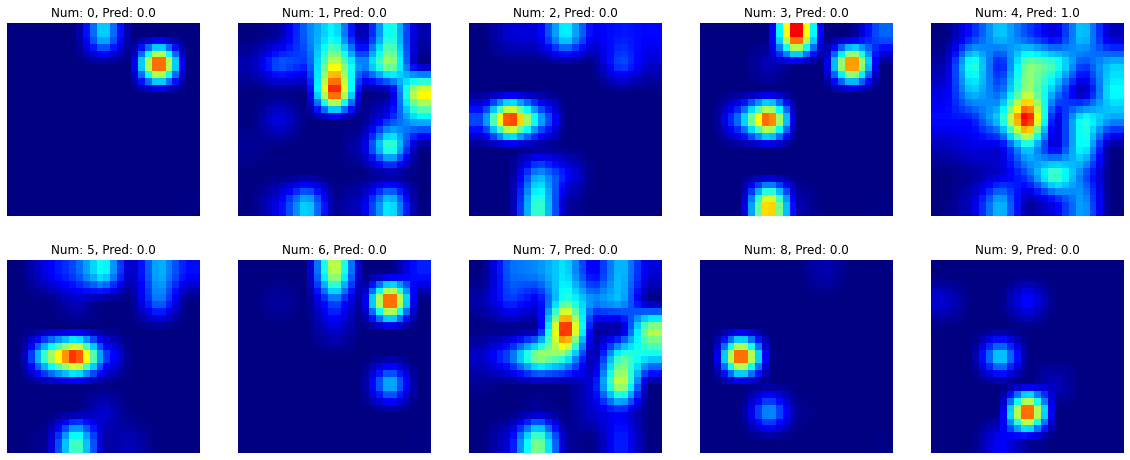

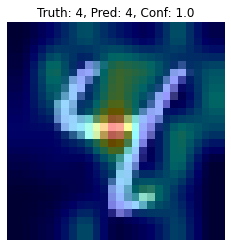

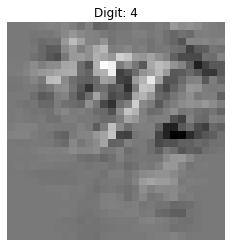

===Example 7/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 9, Pred: 9


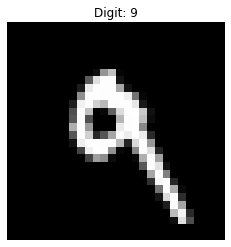

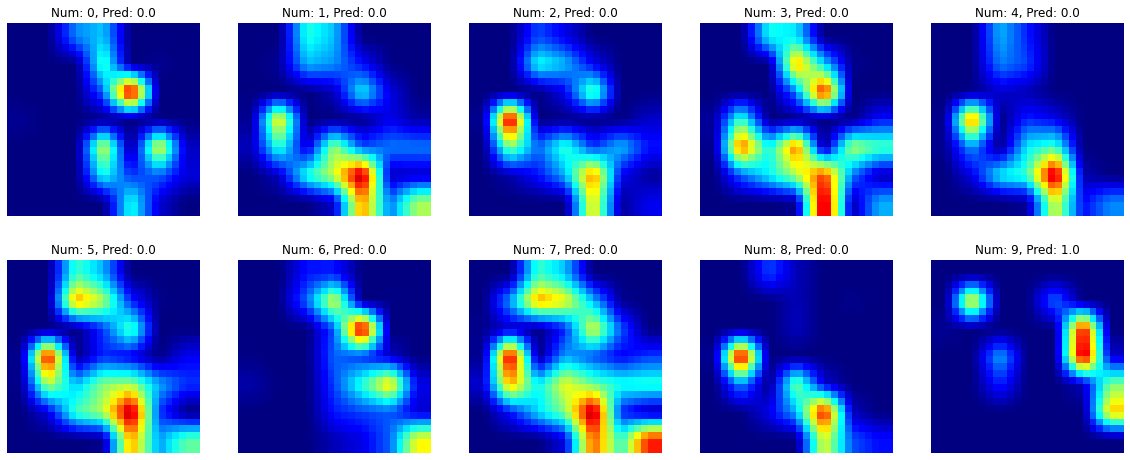

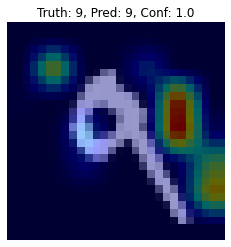

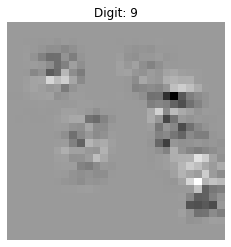

===Example 8/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 5, Pred: 5


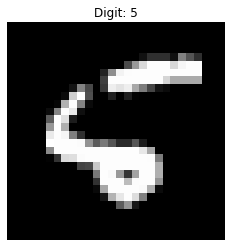

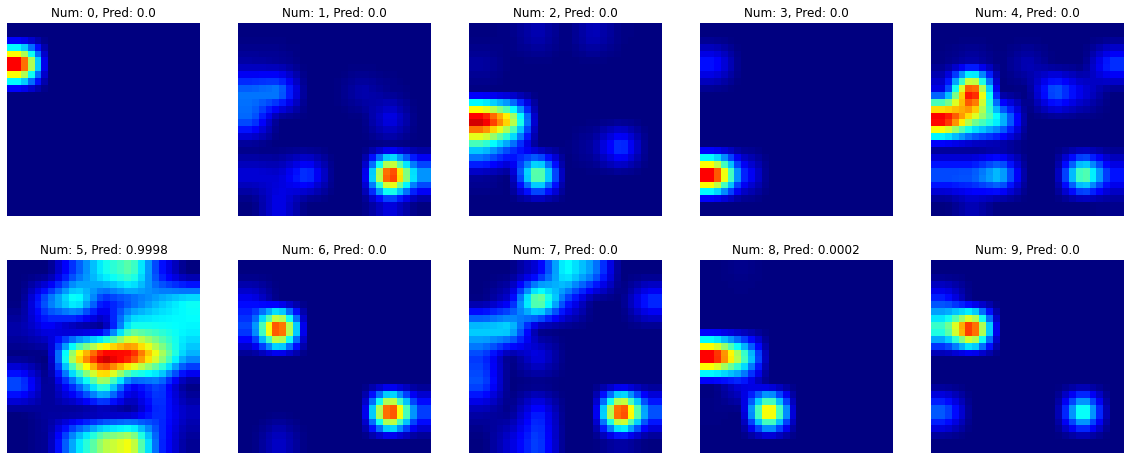

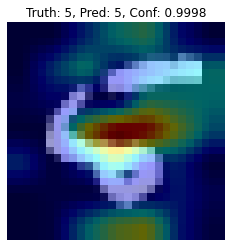

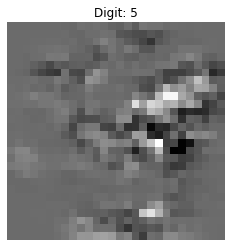

===Example 9/9===
Final Conv Output Size: torch.Size([1, 32, 7, 7])
Class Specific Alphas Size: torch.Size([10, 32])
===Operations===
Truth: 9, Pred: 9


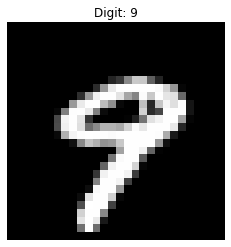

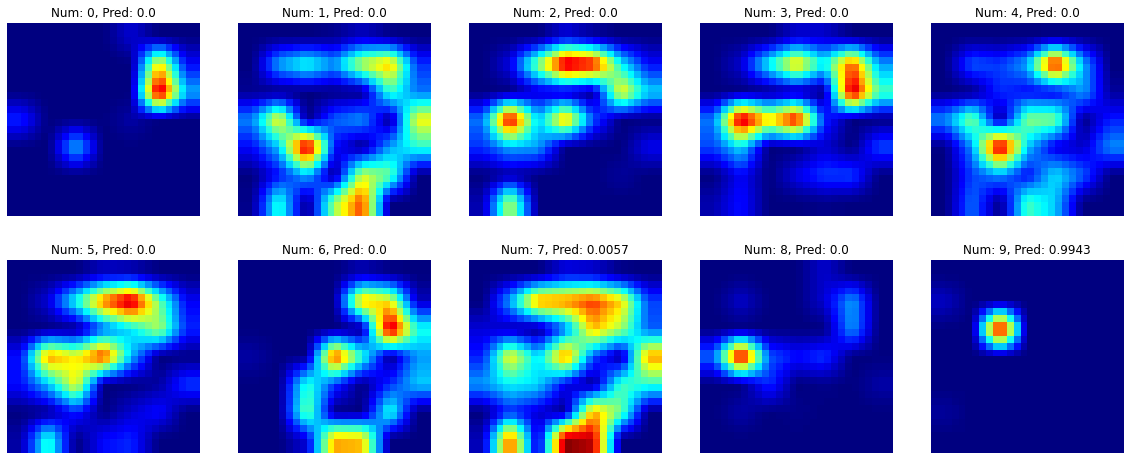

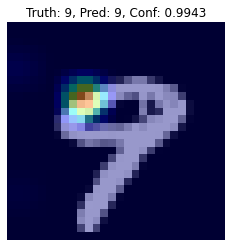

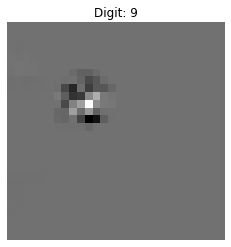

In [10]:
def grad_cam_visualization(model, data, data_index=0, save=False):
  model.eval()

  x, y = data[data_index][0], data[data_index][1]

  class_specific_alphas = torch.tensor((), dtype=torch.float64)
  class_specific_alphas = class_specific_alphas.new_zeros((10, 32))

  for c in range(10):
    model.zero_grad()
    pred, final_conv_output = model(x[None, :])

    final_conv_output.requires_grad_()
    final_conv_output.retain_grad()

    one_hot_output = torch.FloatTensor(1, pred[0].size()[-1]).zero_()
    one_hot_output[0][c] = 1

    # pred[:, c].backward()

    pred.backward(gradient=one_hot_output, retain_graph=True)

    class_specific_alphas[c] = torch.sum(final_conv_output.grad.squeeze(), (1, 2))
  
  class_specific_alphas = torch.div(class_specific_alphas, 7 * 7)

  pred,final_conv_output = model(x[None, :])

  input_gradients = model.get_input_gradients()
  # input_gradients = nn.functional.relu(input_gradients)

  print(f"Final Conv Output Size: {final_conv_output.size()}")
  print(f"Class Specific Alphas Size: {class_specific_alphas.size()}")

  print("===Operations===")

  mult_res = torch.mul(class_specific_alphas[:, :, None, None], final_conv_output)
  sum_res = nn.functional.relu(torch.sum(mult_res, 1))

  pred = nn.functional.softmax(pred[0], dim=-1)

  # === Visualizations ===
  print(f"Truth: {y}, Pred: {pred.argmax(0)}")

  # Initial Digit
  plt.axis("off")
  plt.title(f"Digit: {y}")
  plt.imshow(x.squeeze(), cmap="gray")
  
  if save:
    plt.savefig(f"../images/gradCAM/implemenPics/gradCAMDigit{data_index}")
    plt.close()
  else:
    plt.show()

  # Class-Specific Grad-CAM
  figure = plt.figure(figsize=(20, 8))
  cols, rows = 5, 2

  cam_heatmaps = []

  for i in range(0, cols * rows):
    heatmap = sum_res[i]
    heatmap = torch.sub(heatmap, torch.min(heatmap))
    heatmap = torch.div(heatmap, torch.max(heatmap))

    heatmap = cv2.resize(heatmap.detach().numpy(), (28, 28))

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    cam_heatmaps.append(heatmap)

    figure.add_subplot(rows, cols, i + 1)
    plt.title(f"Num: {i}, Pred: {round(pred[i].item(), 4)}")
    plt.axis("off")
    plt.imshow(heatmap)
  if save:
    plt.savefig(f"../images/gradCAM/implemenPics/gradCAMHeatmaps{data_index}")
    plt.close()
  else:
    plt.show()

  # Grad-CAM Heatmap Overlaid
  plt.figure()
  plt.title(f"Truth: {y}, Pred: {pred.argmax(0)}, Conf: {round(pred.amax(0).item(), 4)}")
  plt.axis("off")
  plt.imshow(x.squeeze(), cmap="gray")
  plt.imshow(cam_heatmaps[pred.argmax(0)], alpha=0.4)
  if save:
    plt.savefig(f"../images/gradCAM/implemenPics/gradCAMOverlay{data_index}")
    plt.close()
  else:
    plt.show()

  # "Guided" Grad-CAM 
  plt.axis("off")
  plt.title(f"Digit: {y}")

  heatmap = sum_res[pred.argmax(0)]
  heatmap = torch.sub(heatmap, torch.min(heatmap))
  heatmap = torch.div(heatmap, torch.max(heatmap))

  heatmap = cv2.resize(heatmap.detach().numpy(), (28, 28))

  plt.imshow(np.multiply(heatmap, input_gradients.squeeze()), cmap="gray")
  
  if save:
    plt.savefig(f"../images/gradCAM/implemenPics/gradCAMDigit{data_index}")
    plt.close()
  else:
    plt.show()

num_graphs = 10
for i in range(num_graphs):
  print(f"===Example {i}/{num_graphs - 1}===")
  grad_cam_visualization(grad_cam_model, test_data, i, False)

## Guided Grad-CAM
High resolution and class specific